# Introduction Azure ML<br> (expérimentations, runs, logs)
<br>

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>


Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/

In this tutorial, you complete the end-to-end steps to get started with the Azure Machine Learning Python SDK running 
in Jupyter notebooks. 

In this tutorial, you:
- Run some Python code
- Log results into an Azure ML experiment
- Save ML models into Azure ML repository
- Use MLFlow integration with Azure ML
- Use Azure OpenDatasets

## Architecture et concepts

> https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture

<img src="https://github.com/retkowsky/images/blob/master/workspace.png?raw=true">

> Architectures Azure : https://docs.microsoft.com/en-us/azure/architecture/browse/

## 0. Paramétrage

In [1]:
import numpy as np

In [2]:
import datetime
maintenant = datetime.datetime.now()
print("Aujourd'hui :", maintenant)

Aujourd'hui : 2020-07-08 07:47:32.075385


In [3]:
import sys
print("Version Python :", sys.version)

Version Python : 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [4]:
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['Platforme']=platform.system()
        info['Platforme-release']=platform.release()
        info['Platforme-version']=platform.version()
        info['Architecture']=platform.machine()
        info['Hostname']=socket.gethostname()
        info['IP-address']=socket.gethostbyname(socket.gethostname())
        info['MAC-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['Processeur']=platform.processor()
        info['RAM']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" Go"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'Platforme': 'Linux',
 'Platforme-release': '4.15.0-1082-azure',
 'Platforme-version': '#92~16.04.1-Ubuntu SMP Tue Apr 14 22:28:34 UTC 2020',
 'Architecture': 'x86_64',
 'Hostname': 'instance',
 'IP-address': '127.0.0.1',
 'MAC-address': '00:0d:3a:bb:18:9c',
 'Processeur': 'x86_64',
 'RAM': '14 Go'}

In [5]:
import azureml.core
from azureml.core import Experiment, Workspace

print("Version Azure ML service :", azureml.core.VERSION)

Version Azure ML service : 1.9.0


> Versions azure ML : https://docs.microsoft.com/en-us/azure/machine-learning/azure-machine-learning-release-notes

In [6]:
# Rappel des infos du workspace Azure ML service
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: workshopAML2020
Azure region: westeurope
Resource group: workshopAML2020-rg


In [7]:
from azureml.core import ComputeTarget, Datastore, Dataset

print("Ressources du workspace")
print()
print("Compute Targets :")
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print("\t", compute.name, ':', compute.type)
    
print("Datastores :")
for datastore_name in ws.datastores:
    datastore = Datastore.get(ws, datastore_name)
    print("\t", datastore.name, ':', datastore.datastore_type)
    
print("Datasets :")
for dataset_name in list(ws.datasets.keys()):
    dataset = Dataset.get_by_name(ws, dataset_name)
    print("\t", dataset.name)

Ressources du workspace

Compute Targets :
	 AutoML : AmlCompute
	 cont-cluster : AmlCompute
	 instance : ComputeInstance
	 Designer : AmlCompute
	 cpu-cluster2 : AmlCompute
Datastores :
	 azureml_globaldatasets : AzureBlob
	 azureml : AzureBlob
	 modelservingdata : AzureBlob
	 aiexportdata : AzureBlob
	 modeldata : AzureBlob
	 teststorageserge : AzureBlob
	 workspaceblobstore : AzureBlob
	 workspacefilestore : AzureFile
Datasets :
	 DefectScores
	 MD-Defect-Train_Model-Trained_model-9b4070d1
	 Failure
	 MD-Maintenance-Train_Model-Trained_model-9b4070d1
	 Maintenance
	 Birds
	 Transactions
	 NOAA-Weather-DS4
	 drift-demo-dataset
	 target
	 dataset
	 Iris
	 mnist dataset
	 diabetes dataset


## 1. Chargement des données

In [19]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import joblib

In [20]:
# scikit-learn version
import sklearn
print("Version scikit-learn :", sklearn.__version__)

Version scikit-learn : 0.23.1


#### Données : DIABETES
From Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499, we have

"Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline."
> https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

In [21]:
X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [22]:
# Taille en % de la base de test
testsizepct=0.20

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsizepct, random_state=0)

data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

In [24]:
nobstrain=len(data['train']['X'])
nobstest=len(data['test']['X'])
print ("Training =", nobstrain, 'observations')
print ("Test =", nobstest, 'observations')

Training = 353 observations
Test = 89 observations


## 2. Modélisation

Nous allons réaliser un modèle de régression **Ridge**.<br> 
<img src='https://github.com/retkowsky/images/blob/master/ridge.png?raw=true'>
<br>
C'est une version régularisée de la régression linéaire.
Cela permet d'ajuster les données avec des coefficents de pondération du modèle les plus petits possibles.
- Si le paramétre = 0 => nous avons dans ce cas une régression linéaire.
- Si le paramétre a une valeur importante, alors les coefficients de pondérations ont des valeurs proches de 0 => on aura dans ce cas une ligne horizontale qui passe par la moyenne des données.



> https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

### Création expérimentation Azure ML

In [25]:
experiment = Experiment(workspace=ws, name="Exemple1-Ridge")

Les étapes
1. Logs d'informations
2. Modélisation
3. Logs de résultats de modèles et graphiques
4. Sauvegarde modèle

In [26]:
def regridge(k):
    
    # 1. On démarre le logging des informations
    run = experiment.start_logging()
    
    print('k =', k)
    print()    
       
    # 2. Logs d'informations au run
    run.log('k', k) # On loggue la valeur de k dans l'expérimentation Azure ML
    run.log('Test Size', testsizepct) # On loggue la valeur dans l'expérimentation Azure ML
    run.log('Nobs Training', nobstrain) # On loggue la valeur dans l'expérimentation Azure ML
    run.log('Nobs Test', nobstest) # On loggue la valeur dans l'expérimentation Azure ML
    
    # 3. Construction d'un modèle de régression Ridge avec la valeur de k comme hyperparamètre
    regression_model = Ridge(alpha=k)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    # 4. Log de la métrique Mean Squared Error du modèle dans l'expérimentation
    from sklearn.metrics import r2_score
    import math
    
    mse = mean_squared_error(data['test']['y'], preds)
    rmse = math.sqrt(mse)
    R2 = r2_score(data['test']['y'], preds)
    
    print('- RMSE =', rmse)
    print('- MSE =', mse)
    print('- R2 =', R2)
    
    run.log("rmse", rmse)
    run.log('mse', mse)
    run.log('R2', R2)

    # 5. Export modèle pour chaque valeur de k
    
    model_name = "RegRidgeModele-k-" + str(k) + ".pkl"
    filename = "outputs/" + model_name
    joblib.dump(value=regression_model, filename=filename)
    run.upload_file(name=model_name, path_or_stream=filename)
    
    # 6. Ajout de tags personnalisés au run
    run.tag("Langage", "Python")
    run.tag("Version_Python", "3.6.9")
    run.tag("Version_AzureML", "1.9.0")
    run.tag("Team", "DataScience France")
    run.tag("Pays", "France") 
    run.tag("Auteur", "Serge") 
    
    # 7. Création et log d'un graphique
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig = plt.figure(1)
    idx = np.argsort(data['test']['y'])
    plt.plot(data['test']['y'][idx],preds[idx])
    
    fig.savefig("RegRidgeGraphique-k-"+str(k)+".png") # On sauvegarde chaque graphique avec un nom personnalisé
    plt.title('Ajustement Régression Ridge', fontsize=10)
    
    run.log_image(name='Ajustement Régression Ridge', plot=plt) # On loggue dans l'expérimentation l'image du graphique
    
    # 6. Fin du run
    run.complete()

### Appels de la fonction

k = 0.1

- RMSE = 58.07451788702194
- MSE = 3372.6496278100317
- R2 = 0.3422976558630023


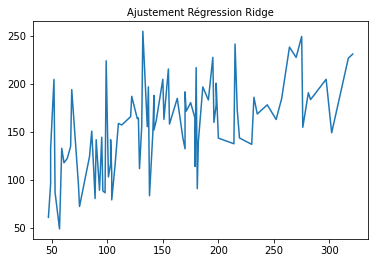

In [34]:
regridge(0.1)

k = 0.2

- RMSE = 57.66536811178679
- MSE = 3325.294679467877
- R2 = 0.3515323715815589


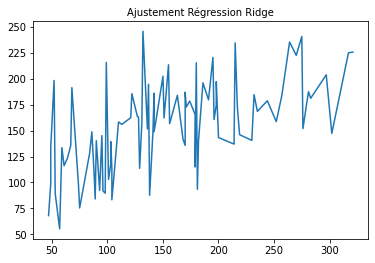

In [35]:
regridge(0.2)

k = 0.3

- RMSE = 57.46889274556911
- MSE = 3302.6736334017255
- R2 = 0.35594371478835374


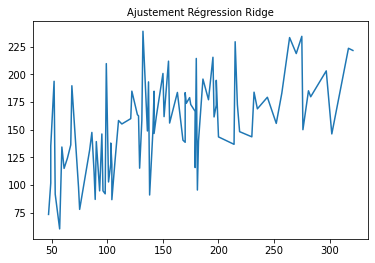

In [36]:
regridge(0.3)

k = 0.4

- RMSE = 57.40854522068826
- MSE = 3295.741064355809
- R2 = 0.3572956390661659


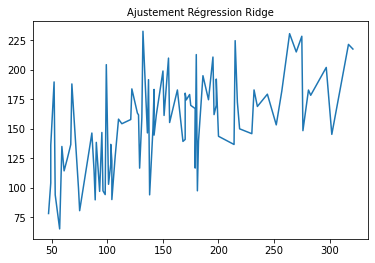

In [37]:
regridge(0.4)

k = 0.5

- RMSE = 57.436135018009885
- MSE = 3298.909605807062
- R2 = 0.3566777399749588


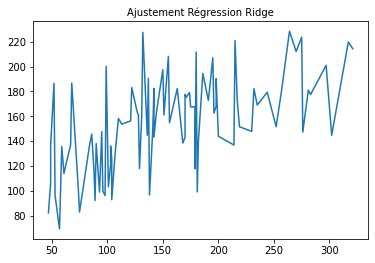

In [38]:
regridge(0.5)

In [39]:
# Liste des pickle des modèles sauvegardés sur le disque
%ls outputs/RegRidgeModele*.pkl -l

-rwxrwxrwx 1 root root 649 Jul  8 07:57 outputs/RegRidgeModele-k-0.1.pkl*
-rwxrwxrwx 1 root root 649 Jul  8 07:57 outputs/RegRidgeModele-k-0.2.pkl*
-rwxrwxrwx 1 root root 649 Jul  8 07:58 outputs/RegRidgeModele-k-0.3.pkl*
-rwxrwxrwx 1 root root 649 Jul  8 07:59 outputs/RegRidgeModele-k-0.4.pkl*
-rwxrwxrwx 1 root root 649 Jul  8 07:59 outputs/RegRidgeModele-k-0.5.pkl*


In [40]:
# Liste des graphiques sauvegardés sur le disque
%ls RegRidgeGraphique*.png -l

-rwxrwxrwx 1 root root 23124 Jul  8 07:57 RegRidgeGraphique-k-0.1.png*
-rwxrwxrwx 1 root root 24895 Jul  8 07:57 RegRidgeGraphique-k-0.2.png*
-rwxrwxrwx 1 root root 24426 Jul  8 07:58 RegRidgeGraphique-k-0.3.png*
-rwxrwxrwx 1 root root 24760 Jul  8 07:59 RegRidgeGraphique-k-0.4.png*
-rwxrwxrwx 1 root root 25443 Jul  8 07:59 RegRidgeGraphique-k-0.5.png*


## Référencement du modèle

Le meilleur modèle (ou le moins mauvais ! :blush:) est pour k=4.
:blush:

In [41]:
monmodelepkl='RegRidgeModele-k-0.4.pkl'
k=0.4
MSE=3295.74
R2=0.36
RMSE = 57.41

In [42]:
from azureml.core.model import Model

model = Model.register(model_path="outputs/"+monmodelepkl, # Référence du pickle
                       model_name="RegressionRidgeML", # Nom du modèle référencé
                       model_framework=Model.Framework.SCIKITLEARN,  # Framework
                       model_framework_version='0.20.3',             # Version scikit-learn
                       tags={'area': 'Diabetes', # Ajout de tags au modèle
                             'type': 'Regression Ridge', 
                             'k':k, 
                             'MSE' : MSE, 
                             'R2' : R2,
                             'RMSE' : RMSE,
                             'Framework' : 'Azure ML SDK'},
                       description="Modèle de régression Ridge", # Description du modèle
                       workspace=ws) # Nom du workspace Azure ML

Registering model RegressionRidgeML


Le modèle est référencé dans le référentiel des modèles Azure ML.

## Informations du modèle référencé

In [43]:
print('Nom du modèle :', model.name)
print('Description :', model.description)
print('ID =', model.id)
print('Version =', model.version)

Nom du modèle : RegressionRidgeML
Description : Modèle de régression Ridge
ID = RegressionRidgeML:2
Version = 2


In [44]:
# Liste des modèles référencés
from azureml.core import Model

for model in Model.list(ws):
    print(model.name, '- version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

RegressionRidgeML - version = 2
	 area : Diabetes
	 type : Regression Ridge
	 k : 0.4
	 MSE : 3295.74
	 R2 : 0.36
	 RMSE : 57.41
	 Framework : Azure ML SDK


census_gs_model_35 - version = 1


census_gs_model_34 - version = 1


census_gs_model_33 - version = 1


census_gs_model_32 - version = 1


census_gs_model_31 - version = 1


census_gs_model_30 - version = 1


census_unmitigated - version = 1


Defect - version = 4
	 Training context : Azure Auto ML SDK
	 AUC : 0.7744069264069265
	 Accuracy : 0.8869565217391304


Defect - version = 3
	 Training context : Azure Auto ML SDK
	 AUC : 0.7744069264069265
	 Accuracy : 0.8869565217391304


amlstudio-defect-real-time-inf - version = 1
	 CreatedByAMLStudio : true


Defect - version = 2
	 Training context : Azure Auto ML SDK
	 AUC : 0.778055275301434
	 Accuracy : 0.8956521739130435


Defect - version = 1
	 Training context : Azure Auto ML SDK
	 AUC : 0.778055275301434
	 Accuracy : 0.8956521739130435


RegressionRidgeML - version = 1
	 area :

## On visualise les métriques pour chaque run

In [47]:
# Liste des métriques par Run
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['Exemple1-Ridge']
for logged_run in diabetes_experiment.get_runs():
    print()
    print('Run ID :', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))


Run ID : c101500d-dddf-4732-a1f2-47a706e2cfbb
- k 0.5
- Test Size 0.2
- Nobs Training 353
- Nobs Test 89
- rmse 57.436135018009885
- mse 3298.909605807062
- R2 0.3566777399749588
- Ajustement Régression Ridge aml://artifactId/ExperimentRun/dcid.c101500d-dddf-4732-a1f2-47a706e2cfbb/Ajustement Régression Ridge_1594195189.png

Run ID : dd7d4b59-217a-4033-8365-eb28fd6f9fee
- k 0.4
- Test Size 0.2
- Nobs Training 353
- Nobs Test 89
- rmse 57.40854522068826
- mse 3295.741064355809
- R2 0.3572956390661659
- Ajustement Régression Ridge aml://artifactId/ExperimentRun/dcid.dd7d4b59-217a-4033-8365-eb28fd6f9fee/Ajustement Régression Ridge_1594195153.png

Run ID : bd5be8ea-792d-4a48-94cd-bc163ccd8f5c
- k 0.3
- Test Size 0.2
- Nobs Training 353
- Nobs Test 89
- rmse 57.46889274556911
- R2 0.35594371478835374
- mse 3302.6736334017255
- Ajustement Régression Ridge aml://artifactId/ExperimentRun/dcid.bd5be8ea-792d-4a48-94cd-bc163ccd8f5c/Ajustement Régression Ridge_1594195117.png

Run ID : 61a8f212-420

Nous pouvons visualiser les résultats sur le portail dans la section **experiments** :

In [48]:
experiment

Name,Workspace,Report Page,Docs Page
Exemple1-Ridge,workshopAML2020,Link to Azure Machine Learning studio,Link to Documentation


## 3. Utilisation MLFlow

<img src="https://docs.microsoft.com/en-us/azure/machine-learning/service/media/how-to-use-mlflow/mlflow-diagram-track.png">

Documentation: https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-use-mlflow

> https://mlflow.org/

In [49]:
import mlflow
import mlflow.sklearn
import azureml.core
from azureml.core import Workspace
import matplotlib.pyplot as plt

In [50]:
# A installer si besoin
#!pip install azureml-mlflow

In [51]:
ws = Workspace.from_config()

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

experiment_name = "Exemple1-MLFlow"
mlflow.set_experiment(experiment_name)

Données : 353 observations d'apprentissage et 89 observations de test.
k = 0.4
Mean Squared Error = 3295.741064355809


2020/07/08 08:02:06 WARNING mlflow.models: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under azureml://experiments/Exemple1-MLFlow/runs/7dc3f539-00f0-4e4f-81b1-ca093aee7a61/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


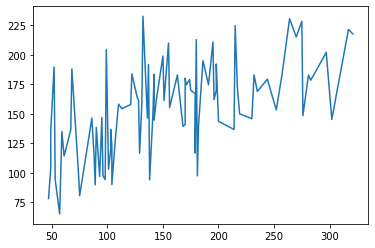

In [52]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

print ("Données :", len(data['train']['X']), "observations d'apprentissage et",len(data['test']['X']), "observations de test.")

model_save_path = "model"

k=0.4

with mlflow.start_run() as run:
    
    mlflow.log_metric('k', k)
    print('k =', k)
    
    regression_model = Ridge(alpha=k)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    print('Mean Squared Error =', mean_squared_error(data['test']['y'], preds))
    mlflow.log_metric('mse', mean_squared_error(data['test']['y'], preds))
    
    mlflow.sklearn.log_model(regression_model,model_save_path)
    
    fig = plt.figure(1)
    idx = np.argsort(data['test']['y'])
    plt.plot(data['test']['y'][idx],preds[idx])
    fig.savefig("GraphiqueMLFlow.png")
    mlflow.log_artifact("GraphiqueMLFlow.png")
    

In [53]:
ws.experiments[experiment_name]

Name,Workspace,Report Page,Docs Page
Exemple1-MLFlow,workshopAML2020,Link to Azure Machine Learning studio,Link to Documentation


## 4. Autres exemples de logging d'informations

In [54]:
experiment = Experiment(workspace=ws, name='Exemple1-Logging')

In [55]:
from tqdm import tqdm

In [56]:
# start logging for the run
run = experiment.start_logging()

# change the scale factor on different runs to see how you can compare multiple runs
scale_factor = 3.14

# change the category on different runs to see how to organize data in reports
category = 'Pi'

In [57]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
Exemple1-Logging,994350f9-9f8d-4f35-ae83-c1c6bbcd275c,,Running,Link to Azure Machine Learning studio,Link to Documentation


In [58]:
experiment

Name,Workspace,Report Page,Docs Page
Exemple1-Logging,workshopAML2020,Link to Azure Machine Learning studio,Link to Documentation


In [59]:
# log chaine de caractères
run.log(name='Category', value=category)

In [60]:
# log donneés numériques
run.log(name="scale factor", value = scale_factor)
run.log(name='Magic Number', value=42 * scale_factor)

In [61]:
fibonacci_values = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89]
scaled_values = (i * scale_factor for i in fibonacci_values)

# Log a list of values. Note this will generate a single-variable line chart.
run.log_list(name='Fibonacci', value=scaled_values)

for i in tqdm(range(-10, 10)):
    # log a metric value repeatedly, this will generate a single-variable line chart.
    run.log(name='Sigmoid', value=1 / (1 + np.exp(-i)))

100%|██████████| 20/20 [00:00<00:00, 11968.34it/s]


In [62]:
# create a dictionary to hold a table of values
sines = {}
sines['angle'] = []
sines['sine'] = []

for i in tqdm(range(-10, 10)):
    angle = i / 2.0 * scale_factor
    
    # log a 2 (or more) values as a metric repeatedly. This will generate a 2-variable line chart if you have 2 numerical columns.
    run.log_row(name='Cosine Wave', angle=angle, cos=np.cos(angle))
        
    sines['angle'].append(angle)
    sines['sine'].append(np.sin(angle))

# log a dictionary as a table, this will generate a 2-variable chart if you have 2 numerical columns
run.log_table(name='Sine Wave', value=sines)

100%|██████████| 20/20 [00:00<00:00, 10349.92it/s]


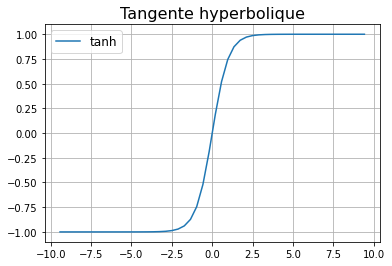

In [63]:
%matplotlib inline

import matplotlib.pyplot as plt
angle = np.linspace(-3, 3, 50) * scale_factor
plt.plot(angle,np.tanh(angle), label='tanh')
plt.legend(fontsize=12)
plt.title('Tangente hyperbolique', fontsize=16)
plt.grid(True)

run.log_image(name='Tangente hyperbolique', plot=plt)

In [64]:
file_name = 'outputs/myfile.txt'

with open(file_name, "w") as f:
    f.write('This is an output file that will be uploaded.\n')

# Upload the file explicitly into artifacts 
run.upload_file(name = file_name, path_or_stream = file_name)

In [65]:
run.complete()

In [66]:
experiment

Name,Workspace,Report Page,Docs Page
Exemple1-Logging,workshopAML2020,Link to Azure Machine Learning studio,Link to Documentation


In [67]:
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['Exemple1-Logging']
for logged_run in diabetes_experiment.get_runs():
    print('Run ID:', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))


Run ID: 994350f9-9f8d-4f35-ae83-c1c6bbcd275c
- Tangente hyperbolique aml://artifactId/ExperimentRun/dcid.994350f9-9f8d-4f35-ae83-c1c6bbcd275c/Tangente hyperbolique_1594195377.png
- Category Pi
- scale factor 3.14
- Magic Number 131.88
- Fibonacci [0.0, 3.14, 3.14, 6.28, 9.42, 15.700000000000001, 25.12, 40.82, 65.94, 106.76, 172.70000000000002, 279.46000000000004]
- Sigmoid [4.5397868702434395e-05, 0.00012339457598623172, 0.0003353501304664781, 0.0009110511944006454, 0.0024726231566347743, 0.0066928509242848554, 0.01798620996209156, 0.04742587317756678, 0.11920292202211755, 0.2689414213699951, 0.5, 0.7310585786300049, 0.8807970779778823, 0.9525741268224334, 0.9820137900379085, 0.9933071490757153, 0.9975273768433653, 0.9990889488055994, 0.9996646498695336, 0.9998766054240137]
- Cosine Wave {'angle': [-15.700000000000001, -14.13, -12.56, -10.99, -9.42, -7.8500000000000005, -6.28, -4.71, -3.14, -1.57, 0, 1.57, 3.14, 4.71, 6.28, 7.8500000000000005, 9.42, 10.99, 12.56, 14.13], 'cos': [-0.999

## 5. Azure Open Datasets

Mise à disposition d'open data dans Azure.
Azure ML permet d'accéder à ces open datasets.

<img src="https://github.com/retkowsky/images/blob/master/opendata.jpg?raw=true">

> https://azure.microsoft.com/fr-fr/services/open-datasets/

In [68]:
#!pip install azureml-opendatasets

In [69]:
# Dataset jours fériés
from azureml.opendatasets import PublicHolidays

from datetime import datetime
from dateutil import parser
from dateutil.relativedelta import relativedelta

In [70]:
# Intervalle en mois
mois=12

In [71]:
import time
datedujour = time.strftime("%d-%m-%Y")
print("Date :", datedujour)

Date : 08-07-2020


In [72]:
fin = datetime.today() + relativedelta(months=mois)
debut = datetime.today() - relativedelta(months=mois)

In [73]:
print("Début :", debut)
print("Fin :", fin)

Début : 2019-07-08 08:03:09.404677
Fin : 2021-07-08 08:03:09.404559


In [74]:
hol = PublicHolidays(start_date=debut, end_date=fin)
joursferies = hol.to_pandas_dataframe()

[Info] read from /tmp/tmp6hst14ad/https/azureopendatastorage.azurefd.net/holidaydatacontainer/Processed/part-00000-tid-1526301832328193421-8ceaef8d-7754-4340-b882-354e543d7759-649-c000.snappy.parquet


In [75]:
joursferies.shape

(1096, 6)

In [76]:
joursferies.head(15)

,countryOrRegion,holidayName,normalizeHolidayName,isPaidTimeOff,countryRegionCode,date
25618,Argentina,Día de la Independencia [Independence Day],Día de la Independencia [Independence Day],None,AR,2019-07-09
25619,Northern Ireland,Battle of the Boyne,Battle of the Boyne,None,None,2019-07-12
25620,United Kingdom,Battle of the Boyne [Northern Ireland],Battle of the Boyne,False,GB,2019-07-12
25621,France,Fête nationale,Fête nationale,None,FR,2019-07-14
25622,Norway,Søndag,Søndag,None,NO,2019-07-14
25623,Sweden,Söndag,Söndag,None,SE,2019-07-14
25624,Japan,海の日,海の日,None,JP,2019-07-15
25625,Belgium,Nationale feestdag,Nationale feestdag,None,BE,2019-07-21
25626,Norway,Søndag,Søndag,None,NO,2019-07-21
25627,Sweden,Söndag,Söndag,None,SE,2019-07-21


In [77]:
# Pour avoir les jours féries en France
joursferiesFR=joursferies[joursferies.countryRegionCode == 'FR']

In [78]:
# Pour avoir la colonne date en 1ere colonne
joursferiesFR = joursferiesFR[ ['date'] + [ col for col in joursferiesFR.columns if col != 'date' ] ]

In [79]:
print("Nombre de jours fériés sur la période :", len(joursferiesFR.index), "jours.")

Nombre de jours fériés sur la période : 22 jours.


In [80]:
joursferiesFR

,date,countryOrRegion,holidayName,normalizeHolidayName,isPaidTimeOff,countryRegionCode
25621,2019-07-14,France,Fête nationale,Fête nationale,None,FR
25647,2019-08-15,France,Assomption,Assomption,None,FR
25716,2019-11-01,France,Toussaint,Toussaint,None,FR
25736,2019-11-11,France,Armistice 1918,Armistice 1918,None,FR
25786,2019-12-25,France,Noël,Noël,None,FR
25851,2020-01-01,France,Jour de l'an,Jour de l'an,None,FR
25999,2020-04-13,France,Lundi de Pâques,Lundi de Pâques,None,FR
26041,2020-05-01,France,Fête du Travail,Fête du Travail,None,FR
26067,2020-05-08,France,Armistice 1945,Armistice 1945,None,FR
26084,2020-05-21,France,Ascension,Ascension,None,FR


In [81]:
# Export fichier CSV
joursferiesFR.to_csv(r'exportjoursferies.csv', index = False)

In [82]:
# Export fichier EXCEL
joursferiesFR.to_excel('exportjoursferies.xlsx')  

In [83]:
%ls exportjoursferies.* -l

-rwxrwxrwx 1 root root 1170 Jul  8 08:03 exportjoursferies.csv*
-rwxrwxrwx 1 root root 6283 Jul  8 08:03 exportjoursferies.xlsx*


In [84]:
# Visu du fichier csv exporté
with open(os.path.join('./exportjoursferies.csv'), 'r') as f:
    print(f.read())

date,countryOrRegion,holidayName,normalizeHolidayName,isPaidTimeOff,countryRegionCode
2019-07-14,France,Fête nationale,Fête nationale,,FR
2019-08-15,France,Assomption,Assomption,,FR
2019-11-01,France,Toussaint,Toussaint,,FR
2019-11-11,France,Armistice 1918,Armistice 1918,,FR
2019-12-25,France,Noël,Noël,,FR
2020-01-01,France,Jour de l'an,Jour de l'an,,FR
2020-04-13,France,Lundi de Pâques,Lundi de Pâques,,FR
2020-05-01,France,Fête du Travail,Fête du Travail,,FR
2020-05-08,France,Armistice 1945,Armistice 1945,,FR
2020-05-21,France,Ascension,Ascension,,FR
2020-06-01,France,Lundi de Pentecôte,Lundi de Pentecôte,,FR
2020-07-14,France,Fête nationale,Fête nationale,,FR
2020-08-15,France,Assomption,Assomption,,FR
2020-11-01,France,Toussaint,Toussaint,,FR
2020-11-11,France,Armistice 1918,Armistice 1918,,FR
2020-12-25,France,Noël,Noël,,FR
2021-01-01,France,Jour de l'an,Jour de l'an,,FR
2021-04-05,France,Lundi de Pâques,Lundi de Pâques,,FR
2021-05-01,France,Fête du Travail,Fête du Travail,,FR
2021

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">